# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called Stochastic Gradient Descent (SGD), to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop ridge regression algorithm (linear regression with $\ell_2$ regularization).

## Instructions
<ol>
	<li>Generate a synthetic dataset suitable for regression and divide it to train and test sets,
    <li>Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and termination threshold $\epsilon$.</li>
	<li> Use the above function and repeat the following until the difference between the old and new weight vectors becomes small (i.e., $d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n$</li>
</ol>
</li>
</ol>
</li>
	<li>Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$</li>
    <li>Plot the training and testing errors vs. iteration number $\tau$.</li>
    <li>Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value</li>
</ol>

## Nomenclature and Naming Convention 
For an easier read, let's link the mathematic notations with their related entities in R.
* $d(x,y)$ : `x-y` is the difference/distance between two points.
* $:=$ : `<-` is the assignment operator.
* $\epsilon$ : `epsilon` is the termination threshold.
* $\tau$ : `tau` is the iteration counter
* $\pmb{w}$ : `W[]` is the vector of weights/coefficients/parameters. In R implementation, we keep a record of all $W$ values for all iterations. Therefore, `W` is a matrix rather than a vector.
* $\pmb{w}^{\tau}$ : `W[tau,]` is the weights vector at iteration `tau`.
* $\eta$ : `eta` is the learning rate.
* $t$ : `target` is the true value of the target variable. For simplicity, sometimes `train.target` is renamed to `T`.
* $\pmb{\phi}$ : `Phi` is the observation vector after the basis function is applied.
* $\pmb{\phi}_n$ : `Phi[i,]` is the `i`-th (or $n$-th) datapoint.

## Implementation
### Synthetic Dataset (Step 1)
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a weight vector (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

In [1]:
library(IRdisplay)
library(ggplot2)  # for plotting functions.
library(reshape2) # for melt and cast functions
set.seed(1234)    # to make the results of stochastic methods reproducible

# geberate N x D data samples
N <- 200         # number of all data point (test and train)
D <- 4           # number of features/attributes/columns i.e. x values

#### Generate features (X)
Create a matrix of values between 0 and 1 that has $N$ rows and $D$ columns. Effectively generates a total of $N$ random data points for $D$ variables.

In [2]:
# NxD dataframe:
data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D))   

# Let's have a look
head(data) 

X1,X2,X3,X4
<dbl>,<dbl>,<dbl>,<dbl>
0.1137034,0.6607546,0.6862423,0.2809718
0.6222994,0.5283594,0.4166287,0.1741882
0.6092747,0.3174938,0.7570262,0.1702244
0.6233794,0.7678555,0.7757949,0.5605436
0.8609154,0.5263085,0.5735870,0.4288006
0.6403106,0.7323019,0.1886988,0.3891868


#### Generate the targets (Y)
We are trying to generate a data set that is based off a linear equation with $D$ dimensions (4 in this example). That means we have an equation of $y = w_0x^0 + w_1x^1 + w_2x^2 + w_3x^3 + w_4x^4$ or $y = w_0 + w_1x + w_2x^2 + w_3x^3 + w_4x^4$ . In the last piece of code we created the $X$ values. We are now going to create the $W$ values.

In [3]:
# This creates a matrix of coefficients (W) for each of the terms in a linear equation. 
# There are D+1 rows because a linear equation also has a W0 coefficient 

coeff <- matrix(c(-5,-3,4,5,10), nrow=D+1, ncol=1)
print(coeff)

     [,1]
[1,]   -5
[2,]   -3
[3,]    4
[4,]    5
[5,]   10


Next, the $Y$ values are created and added to the data. To do this we effectively need to perfrom the multiplication operations on the aforementioned equation. The easiest way to do this for all $N$ data points is to use a matrix.
We need to first include $w_0$ in our x-dataset. Given $w_0$ is the same as $1\times w_0$ the code simply adds a column of 1 as the first column of our `data`. Each row of our 5 columns dataset now represents a vector $<1,x_1,x_2,x_3,x_4>$. If we matrix multiple using `%*%` we end up solving the equation for $y$.

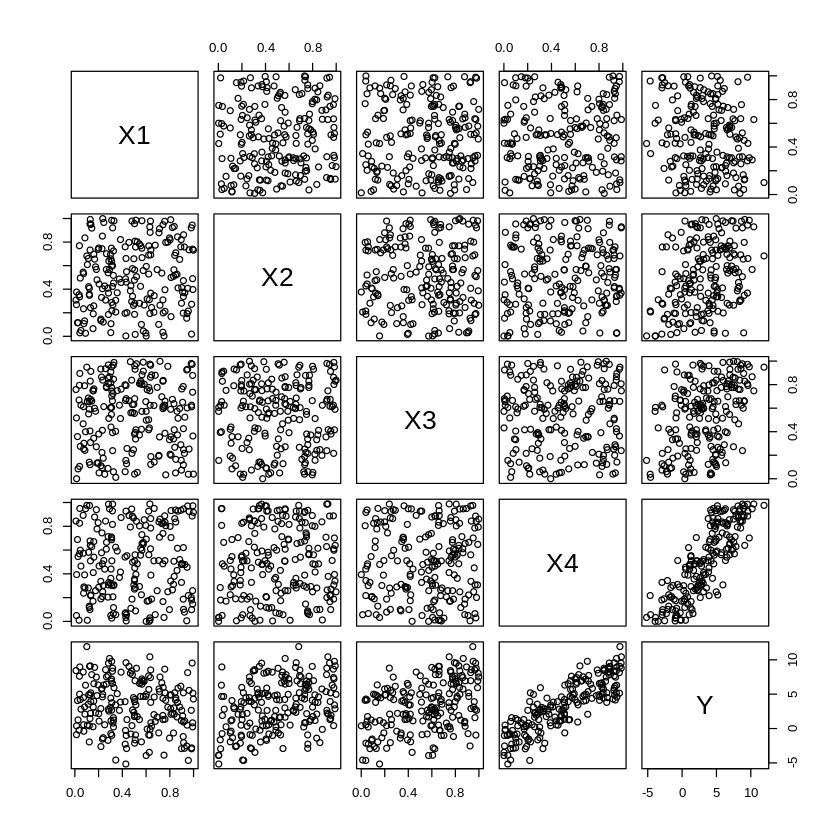

In [4]:
data <- cbind(data,'Y'=as.matrix(cbind(1,data[,1:D])) %*% coeff)
pairs(data)

Let's add some gaussian noise to the target variable to make it a little bit more challenging.

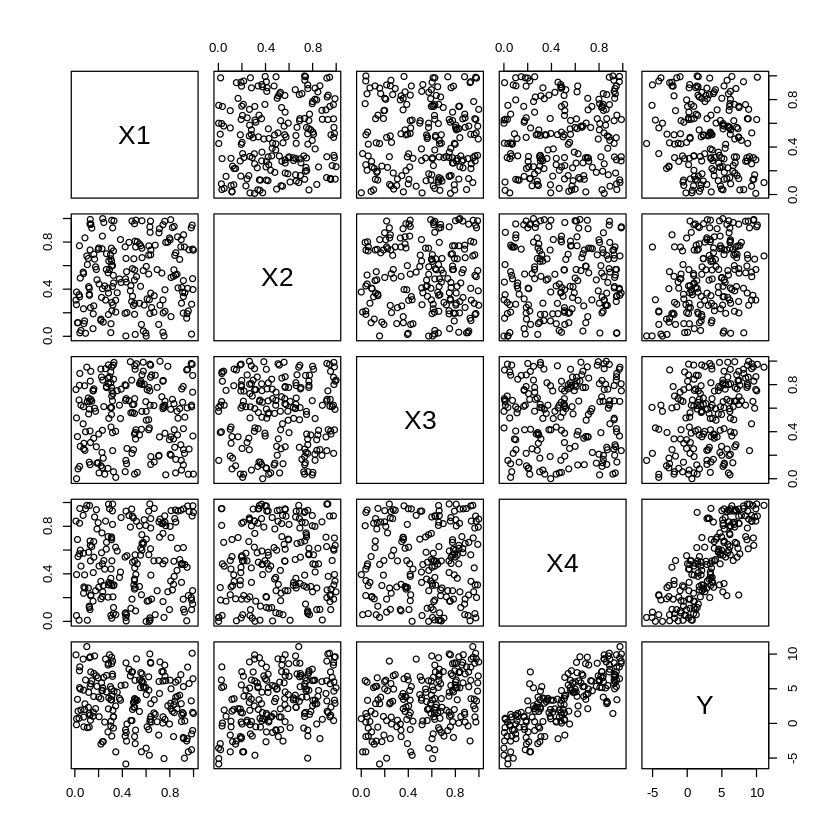

In [5]:
data$Y <- data$Y + rnorm(N, mean = 0, sd =1)  # This is a randomised sample from a normal distribution of sd 1
pairs(data)

### Splitting
Now, divide the dataset into testing and training sets

In [6]:
# divide data into training and testing sets
train.len <- N/2
test.len = N - train.len

train.index <- sample(1:N,train.len)

train.data <- data[train.index,  1:D]
train.target <- data[train.index, 'Y']

test.data <- data[-train.index, 1:D]
test.target <- data[-train.index, 'Y']

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

#### Predict Function
It's an auxiliary function that calculates the target values based on the estimated coefficients.

In [7]:
predict_func <- function(Phi, w){
    # Phi is the basis function so y(x,w) is simply w * Phi(x). Therefore we use matrix multiplication %*%
    return(Phi%*%w)  
} 

#### Error Function
This is a helper function that calculates the cost of the misprediction. The cost function for linear regression is simply $E(w)$ which is $1/2$ of the sum of squared error. In our case the actual value is `target` and the predicted value is $Phi(x) * w$, that we created a value for in the `predict_func` function above. 

In [8]:
error_func <- function (Phi, w, target){
    return(0.5 * sum((predict_func(Phi, w) - target)^2))
}

####  RMSE Function
This function returns Root Mean Square Error (RMSE). 

In [9]:
rmse_func <- function (Phi, w, target){
    return (sqrt(sum((predict_func(Phi, w) - target)^2)/length(target)))
}

#### Termination Function
The training loop should terminate if:
* the iteration $\tau$ exceeds the maximum set `tau.max` OR
* the actual derivatie (sum of squares) is less than the threshold set (i.e. `epsilon`)

In [10]:
terminate_func <- function (tau, tau.max, Phi, w, target){ 
    return (tau >= tau.max | error_func(Phi, w, T) <= epsilon)
}


Now, based on the instruction, we initialize the parameter values.

### Initialization

In [11]:
T       <- train.target # rename just for conviniance
tau.max <- 10000        # maximum number of iterations
eta     <- 0.01         # learning rate
tau     <- 1            # iteration counter

In [12]:
# project data using a basis function (identical here)
# this adds a column of 1 as phi_0 because we define phi_0(x):=1 as a dummy basis function
Phi <- as.matrix(cbind('X0'=1, train.data)) 
head(Phi)

,X0,X1,X2,X3,X4
125,1,0.4861354,0.33928338,0.5630180,0.4979119
68,1,0.5085476,0.01596063,0.3931208,0.2846531
145,1,0.3569871,0.36969649,0.7487494,0.5919763
45,1,0.3297702,0.98021271,0.9885015,0.3069721
9,1,0.6660838,0.20440245,0.6223585,0.5094248
190,1,0.7425694,0.94703798,0.6160606,0.1667424


Epsilon ($\epsilon$) is the threshold to stop iterating because small step changes generally means the gradient will never exactly reach 0 so we can stop when [close enough](https://mashimo.wordpress.com/2014/03/09/gradient-descent/)!
Here 10% of the mean training $T$ values is being used.

In [13]:
# a threshold on the cost (to terminate the process)
epsilon <- 0.1 * mean(T) 

We need to create a space to store our estimated coefficients from the algorithm. Here a matrix is created with blank values (to be written in the main loop) that has number of iterations `tau.max` rows for each iteration and a value for each of the coefficients $\Phi$.

In [14]:
# be used to store the estimated oefficients
W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) 

Now, we set the very first row to a random set of values between 0 and 1 for each variable. This creates the initial weight that the algorithm will iterate over. Uniform random seems fine, so long as the values are already normalised.

In [15]:
# initial weight (any better idea?)
W[1,] <- runif(ncol(Phi)) 

In [16]:
# to be used to trace the test and training errors in each iteration
error <- data.frame('tau'=1:tau.max)  

### Main Loop
Now, we need to run the main training loop. Note that:
* The loop should iteration until `termination_func` returns `TRUE`. 
* For the first iteration `tau = 1` and `W[tau,]` is the weights we randomly assigned in initialization step.
* In each iteration, we chuffle the training data and hence `Phi` and `T`.
* Each set of values for $\pmb{w}^\tau$ is evaluated against the full set of $\pmb{\phi}$ values hence `error_func(Phi, W[tau,],T)` with  no slicing of Phi.
* For each data point $\pmb{\phi}_n$, we need to calculate $\nabla E(\pmb{w}) = -(t_n - \pmb{w}^\tau \pmb{\phi}_n)\pmb{\phi}_n$ and then update the $\pmb{w}^{\tau+1}$ by subtracting $\eta * \nabla E(\pmb{w})$ from the current value of $\pmb{w}^\tau$.
* $\nabla E(\pmb{w}) = -(t_n - \pmb{w}^\tau \pmb{\phi}_n)\pmb{\phi}_n$ can be written as:
  * `-(T[i] - Phi[i,] %*% W[tau,]) * Phi[i,j]` or 
  * `-(T[i] - predict_func(Phi[i,], W[tau,]) * Phi[i,j]` ($n$ here is the same as `i`).
* $\pmb{w}^{\tau+1} := \pmb{w}^{\tau} - \eta  \nabla E(\pmb{w}) = \pmb{w}^{\tau+1} - -\eta(t_n - \pmb{w}^\tau \pmb{\phi}_n)\pmb{\phi}_n = \pmb{w}^{\tau+1} + \eta(t_n - \pmb{w}^\tau \pmb{\phi}_n)\pmb{\phi}_n$ can be implemented as:
  * `W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]`
  * where `t_pred` is `Phi[i,] %*% W[tau,]` (we need to loop over `j` for each single coefficient).

In [17]:
# Iterate until the terminate flag is TRUE 
while(!terminate_func(tau, tau.max, Phi, W[tau,], T)){
    
    # shuffle data (sample without replacement 1:training size):
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    
    # update Indices after shuffling:
    Phi <- Phi[train.index,]  # Select from the training data loaded into Phi based on the random sample
    T   <- T[train.index]     # Grab the predicted Y values for those samples
    
    
    
    # For each datapoint perfrom the error calculation based on our predictions and update W:
    for (i in 1:train.len){
        
        # Run the prediction function
        t_pred = predict_func(Phi[i,], W[tau,])   
        
        # We need to know which way to update our weights for w values. We do this by finding the negative
        # direction of the gradient and shifting the value of W by that amount for the next iteration.
        # To do that we need to find that value for each X variable (i.e. partial derivative)
        
        # for each coefficient:
        for (j in 1: ncol(W)){
            
            # Here we will use the partial derivative equation for the negative gradient:
            # nabla E(w) = -[tn - w * phi(xn)]*phi(xn)
            # Notice that w * phi(xn) is exactly the equation we used in the "predict_func"
            # Therefore this equation is -[actual y - predicted y] * xn value at that n
           
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]  
            
            # This means that the next iteration weight should be equal to the last iteration + our change
            # Note that eta is our learning step. We want to update our weights by a factor of the learning rate
            # (T[i]-t_pred) * Phi[i,j] = (Y value - Predicted Y value) * training x value
            # Phi[i,j] = the value of the x variable in the training set at iteration i and variable j
            
        }

        # Once we have calculated the step change we need to make for each x variable and updated our weights
        # We can calculate the overall sum-of-squares error function based on those values. We do this by passing
        # to the "error_func" function we created earlier.
        # This function is taking our 4 predictions for the coefficients (w) and predicting the y value
        # for eavery example in the training set. It then does this again on the test set
        
        # record the error:
        error[tau, 'train'] <- rmse_func(as.matrix(cbind(1, train.data)), W[tau,],train.target)
        error[tau, 'test']  <- rmse_func(as.matrix(cbind(1, test.data)),  W[tau,],test.target)
        
        if (tau %% 1000 == 0){
            display_markdown(paste("𝜏: ", tau, '$e$:', error[tau, 'train']))
        }
        
        # update the counter:
        tau <- tau + 1  
        
        # check termination criteria:
        if (terminate_func(tau, tau.max, Phi, W[tau,], T)) 
            # break the loop and terminate training phase
            break
    }
}

# Dropping the NAs at the end
error <- error[1:tau-1,]
W     <- W[1:tau,]

cat('The  real coefficents are:',coeff,
    '\nThe  final coefficents are:',W[tau,], '\n\n')

cat('The final training error is:', tail(error$train, 1), '\n')
cat('The final testing error is: ', tail(error$test, 1))



𝜏:  1000 $e$: 1.96325179786156

𝜏:  2000 $e$: 1.38360535999664

𝜏:  3000 $e$: 1.17222267819729

𝜏:  4000 $e$: 1.09137890191509

𝜏:  5000 $e$: 1.05945363921449

𝜏:  6000 $e$: 1.05128754704542

𝜏:  7000 $e$: 1.04082188690648

𝜏:  8000 $e$: 1.03805417547884

𝜏:  9000 $e$: 1.03698613064386

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.922834 -3.322868 4.27025 4.820343 9.94146 

The final training error is: 1.037881 
The final testing error is:  0.9960954

##### Alternative implementation
The inner `for` loop could be implemented as `W[(tau+1),] <- W[tau,] + rep(eta,D+1) * rep((T[i]-t_pred),D+1) * Phi[i,]`. The `rep(x,D+1)` repeats a single value `x` $D+1$ times.

### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

tau,dataset,RMSE
<int>,<fct>,<dbl>
1,train,4.344951
2,train,4.410133
3,train,4.420024
4,train,4.400373
5,train,4.396563
6,train,4.371335


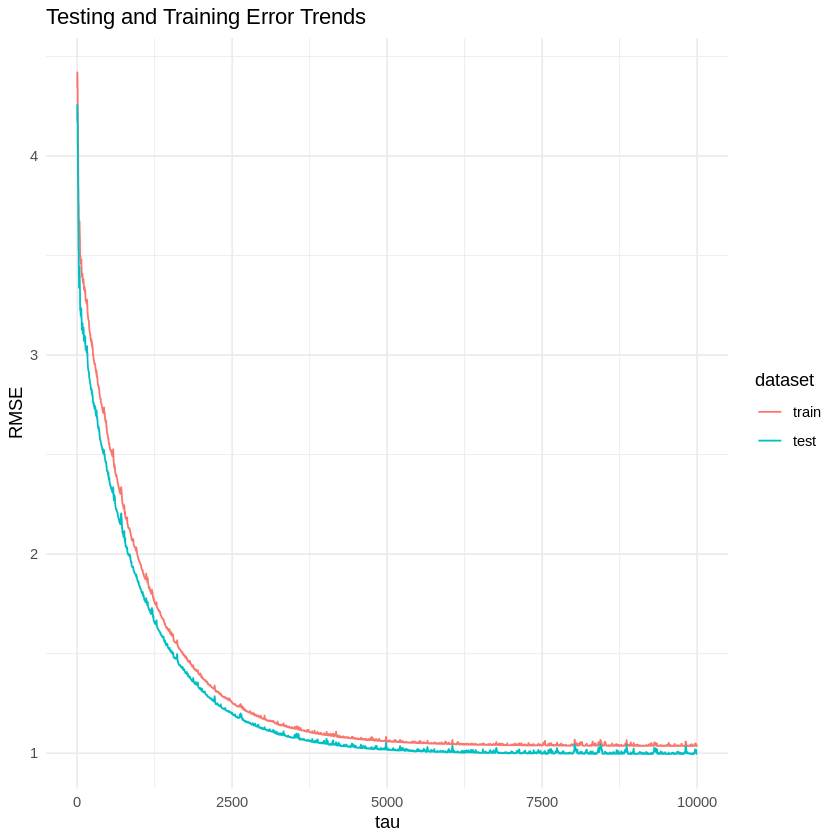

In [18]:
# prepare error dataframe for visualization:
error.m <- melt(error, id='tau')
names(error.m)<-c('tau','dataset','RMSE')
head(error.m)

# plot it
ggplot(data=error.m, aes(x=tau, y=RMSE, color=dataset)) +
    geom_line() + 
    ggtitle('Testing and Training Error Trends') +
    theme_minimal()

Now let's plot the elements of the learned weight vectors over the training iterations.

w0,w1,w2,w3,w4,tau
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.2582441,0.8269377,0.2597852,0.11631531,0.4190053,1
0.1952288,0.7687473,0.2120158,0.10271012,0.4140819,2
0.1872857,0.7632380,0.2075175,0.09654219,0.4120313,3
0.2031794,0.7774817,0.2205623,0.09903839,0.4196434,4
0.2061979,0.7802230,0.2216917,0.10100000,0.4210969,5
0.2285917,0.7914646,0.2323743,0.11343456,0.4290755,6


tau,coefficient_names,coefficient_values
<int>,<fct>,<dbl>
1,w0,0.2582441
2,w0,0.1952288
3,w0,0.1872857
4,w0,0.2031794
5,w0,0.2061979
6,w0,0.2285917


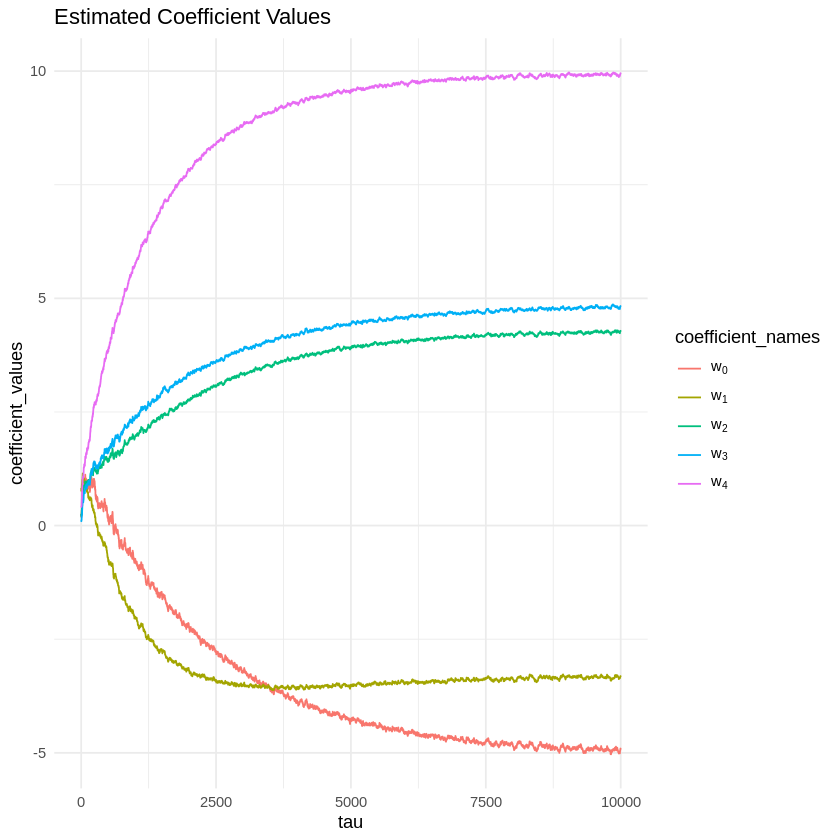

In [19]:
# let's convert W matrix to a W dataframe
W.df <- as.data.frame(W); names(W.df)<-c('w0','w1','w2','w3','w4')
W.df$tau<-1:nrow(W.df)
head(W.df)

# now, melt it to a long table for easier visualization
W.m <-melt(W.df, id='tau'); 
names(W.m) <- c('tau', 'coefficient_names', 'coefficient_values')
head(W.m)

ggplot(data=W.m, aes(x=tau, y=coefficient_values, color=coefficient_names)) + 
    geom_line() + 
    ggtitle('Estimated Coefficient Values') + 
    theme_minimal() + 
    scale_color_discrete(labels = c(expression(w[0]),
                                    expression(w[1]),
                                    expression(w[2]),
                                    expression(w[3]),
                                    expression(w[4])))

## Discussions
1. How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.
2. Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).
3. Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD. 